**Author: Yaohong Liang**

# Set Up

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/marketing-insights-for-e-commerce-company/Online_Sales.csv
/kaggle/input/marketing-insights-for-e-commerce-company/CustomersData.xlsx
/kaggle/input/marketing-insights-for-e-commerce-company/Marketing_Spend.csv
/kaggle/input/marketing-insights-for-e-commerce-company/Discount_Coupon.csv
/kaggle/input/marketing-insights-for-e-commerce-company/Tax_amount.xlsx


In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

# Part 1: Import Data
<a id="Import"></a>

In [3]:
customer_raw = pd.read_excel(r"/kaggle/input/marketing-insights-for-e-commerce-company/CustomersData.xlsx")
coupon_raw = pd.read_csv(r"/kaggle/input/marketing-insights-for-e-commerce-company/Discount_Coupon.csv")
market_spend_raw = pd.read_csv(r"/kaggle/input/marketing-insights-for-e-commerce-company/Marketing_Spend.csv")
sales_raw = pd.read_csv(r"/kaggle/input/marketing-insights-for-e-commerce-company/Online_Sales.csv")
tax_raw = pd.read_excel(r"/kaggle/input/marketing-insights-for-e-commerce-company/Tax_amount.xlsx")

In [4]:
print("Customer Data: ")
display(customer_raw.shape)
display(customer_raw.head(2))

print("Coupon Data: ")
display(coupon_raw.shape)
display(coupon_raw.head(2))

print("Marketing Spend Data: ")
display(market_spend_raw.shape)
display(market_spend_raw.head(2))

print("Sales Data: ")
display(sales_raw.shape)
display(sales_raw.head(2))

print("Product Tax Data: ")
display(tax_raw.shape)
display(tax_raw.head(2))

Customer Data: 


(1468, 4)

,CustomerID,Gender,Location,Tenure_Months
0,17850,M,Chicago,12
1,13047,M,California,43


Coupon Data: 


(204, 4)

,Month,Product_Category,Coupon_Code,Discount_pct
0,Jan,Apparel,SALE10,10
1,Feb,Apparel,SALE20,20


Marketing Spend Data: 


(365, 3)

,Date,Offline_Spend,Online_Spend
0,1/1/2019,4500,2424.50
1,1/2/2019,4500,3480.36


Sales Data: 


(52924, 10)

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status
0,17850,16679,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used
1,17850,16680,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used


Product Tax Data: 


(20, 2)

,Product_Category,GST
0,Nest-USA,0.1
1,Office,0.1


# Part 2: Data Exploration

In [5]:
sales = sales_raw.copy()

In [6]:
# create auxiliary column for joining
sales['Transaction_Date'] = sales_raw['Transaction_Date'].astype('datetime64[ns]')
sales['Transaction_Month'] = sales['Transaction_Date'].dt.strftime('%b')

In [7]:
# consolidate data on customer level

sales = sales.merge(
    customer_raw, on = ['CustomerID'], how = 'left'
).merge(
    coupon_raw.rename(columns = {'Month': 'Transaction_Month'}), 
    on = ['Product_Category', 'Transaction_Month'], how = 'left'
).merge(
    tax_raw, on = ['Product_Category'], how = 'left'
)

# Exploring the Data

## Key Definitions

**Invoice Value** = $\frac{Quantity\ * Avg_price}{1-Dicount_pct}$ * (1+GST)  + Delivery_Charges

**Average order value** = Revenue / Transaction per customer

**Profit margin**: Profit margin is the commonly used profitability ratio. It represents how much
percentage of total sales has earned as the gain.

**Purchase Frequency**: 

The average number of purchases made by a customer over a defined period
of time (typically one month or one year). 

Purcahse Frequency = $\frac{total\ number\ transactions}{total\ number\ customers}$

**Repeat rate**: the percentage of your current customer base that has come back to shop
again.

**Churn Rate**: The annual percentage rate at which customers stop subscribing.

**Customer lifetime value**: lifetime customer value, or life-time value is a prediction of the net
profit/revenue attributed to the entire future relationship with a customer.

## Perform Detailed exploratory analysis

- Understanding how many new customers acquired every month
- Understand the retention of customers on month on month basis
- How the revenues from existing/new customers on a monthly basis
- How the discounts playing role in the revenues?
- Analyse KPI’s like Revenue, number of orders, average order value, number of
customers (existing/new), quantity, by category, by month, by week, by day etc…
- Understand the trends/seasonality of sales by category, location, month etc…
- How number order varies and sales with different days?
- Calculate the Revenue, Marketing spend, percentage of marketing spend out of
revenue, Tax, percentage of delivery charges by month.
- How marketing spend is impacting on revenue?
- Which product was appeared in the transactions?
- Which product was purchased mostly based on the quantity?

In [8]:
# get cohort vintages
sales['Transaction_Month'] = sales['Transaction_Date'].astype('datetime64[ns]').dt.strftime('%Y-%m-01')

### Q1: How many new customers acquired every month?

In [9]:
# calculate the first transaction for every customer
first_purchase = sales.groupby('CustomerID')['Transaction_Month'].min().reset_index()

In [10]:
sales = sales.merge(first_purchase.rename(columns = {'Transaction_Month': 'Cohort_Month'}), 
                       on = ['CustomerID'],
                       how = 'left')

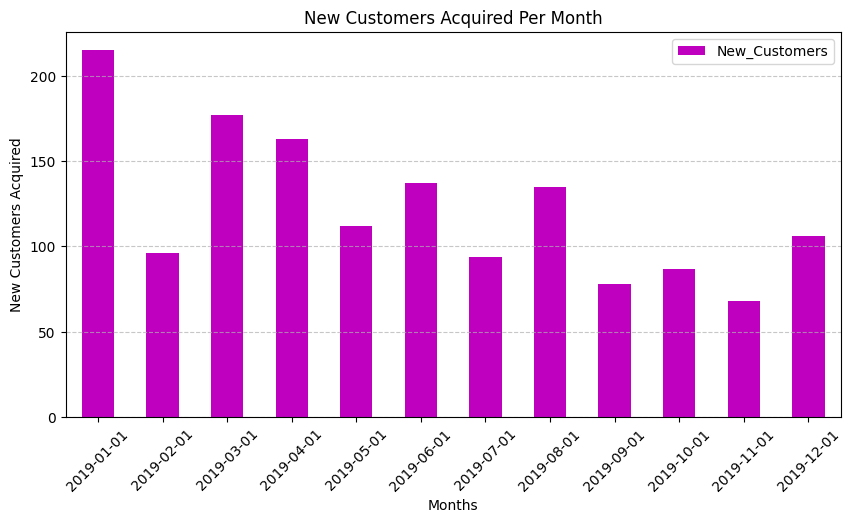

In [11]:
# Plot new customers acquired per month
new_customers_per_month = sales.groupby('Cohort_Month')['CustomerID'].nunique().reset_index(name='New_Customers')
new_customers_per_month.plot(x='Cohort_Month', y='New_Customers', color='m', kind='bar', figsize=(10,5))

# Customize the plot
plt.xlabel("Months")
plt.ylabel("New Customers Acquired")
plt.title("New Customers Acquired Per Month")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

**Observation:**

According to the graph, January saw the highest number of new customers acquired and we obtained more new customers in the first half of this year. There appears to be a general decline in customer acquisition from mid-year (June onward) until a recovery in December.

Some noticable dips and low points:
- February 2019 had a significant drop in new customer acquisitions compared to January.
- September and November 2019 had some of the lowest numbers of new customers.

**Possible Explaination:**

The customer acqusition numbers fluctuate, suggesting external factors (such as promotions, holidays, or market conditions) might be influencing acquisition. 

The high number of new customers in January could be due to New Year promotions or increased consumer activity at the beginning of the year.

The dip in February could be due to post-holiday season fatigue or lower marketing efforts.

**Recommendation:**

If the trend repeats in other years, seasonal campaigns might be effective to counteract low periods.

Understanding the reason behind the December increase can help in planning future strategies to sustain higher acquisition rates.

### Q2: The retention of customers on a monthly basis

$$Retention Rate = \frac{total\ number\ of\ customers\ this\ month - total\ number\ of\ new\ customers\ acquired\ this\ month}{total\ number\ of\ customers\ in\ previous\ month} * 100\%$$

In [12]:
# Count total customers per month (Unique customers)
total_customers_per_month = sales.groupby('Transaction_Month')['CustomerID'].nunique().reset_index()
total_customers_per_month.rename(columns={'CustomerID': 'Total_Customers'}, inplace=True)

In [13]:
# Merge total customers and new customers data
customer_summary = pd.merge(total_customers_per_month, new_customers_per_month, 
                            left_on='Transaction_Month', right_on='Cohort_Month', how='left')
customer_summary.drop(columns=['Cohort_Month'], inplace=True)
customer_summary.fillna(0, inplace=True)  # Fill NaN values (if any) with 0

In [14]:
# Calculate Retention Rate
customer_summary['Previous_Total_Customers'] = customer_summary['Total_Customers'].shift(1)  # Shift total customers by 1 month
customer_summary['Retention_Rate'] = ((customer_summary['Total_Customers'] - customer_summary['New_Customers']) / customer_summary['Previous_Total_Customers']) * 100

In [15]:
customer_summary.tail()

,Transaction_Month,Total_Customers,New_Customers,Previous_Total_Customers,Retention_Rate
7,2019-08-01,300,135,236.0,69.915254
8,2019-09-01,193,78,300.0,38.333333
9,2019-10-01,210,87,193.0,63.730570
10,2019-11-01,188,68,210.0,57.142857
11,2019-12-01,236,106,188.0,69.148936


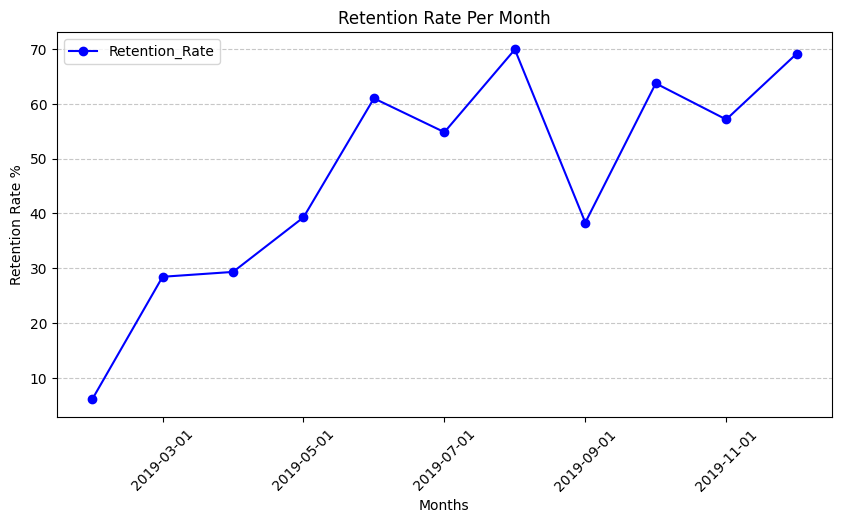

In [16]:
customer_summary.plot(x='Transaction_Month', y='Retention_Rate', 
                      color='#0000FF', figsize=(10,5), marker='o', linestyle='-')

# Customize the plot
plt.xlabel("Months")
plt.ylabel("Retention Rate %")
plt.title("Retention Rate Per Month")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

**Observation:**

1. Overall Trend

- The retention rate fluctuates throughout the year, with some months experiencing significantly higher retention rates than others.

- There is an upward trend from February to mid-year, followed by fluctuations towards the end of the year.

2. Low Retention Periods

- Due to lack of data, early 2019 saw low retention rate.

- September 2019 saw a noticeable dip in retention.

3. High Retention Periods

- June, August, October, and December 2019 had some of the highest retention rates, exceeding 60%.

- These months might coincide with strong customer engagement efforts, promotions, or seasonal shopping behavior.
August 2019 saw the peak retention rate (~70%), suggesting customer stickiness during that time.

**Recommendations:**

Retention Campaigns for Low Months - Implement strategies like re-engagement emails, loyalty programs, and discounts to improve retention, especially in September.

Perform cohort retention analysis to see how long customers from each acquisition period stay active.


### Q3: The revenues from existing/new customers on month on month basis

Total revenue = revenue from new customers + revenue from existing customer

In [17]:
# calculate revenue
sales['Revenue'] = sales['Quantity'] * sales['Avg_Price']

# classify customer type
sales['Is_New_Customer'] = sales.apply(lambda x: True if x['Transaction_Month'] == x['Cohort_Month'] else False, axis=1)

<Axes: xlabel='Transaction_Month'>

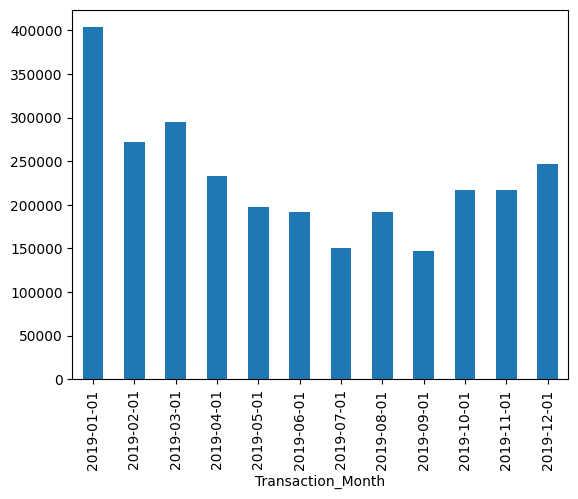

In [18]:
# Revenue from new customers each month
sales[sales['Is_New_Customer'] == True].groupby('Transaction_Month')['Revenue'].sum().plot(kind = 'bar')

<Axes: xlabel='Transaction_Month'>

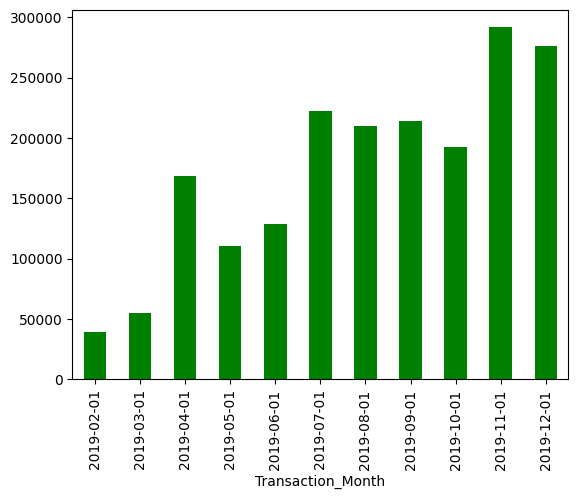

In [19]:
# Revenue from existing customers each month
sales[sales['Is_New_Customer'] == False].groupby('Transaction_Month')['Revenue'].sum().plot(kind = 'bar', color = 'green')

**Observation:**

The revenues from new customers are uneven across the year. January cohort appears to have the most revenue and the trend went down until July. This agrees with what we know about the trend of new customers acquired over the year. Cohorts in the second half of 2019 showed a resilient sales performance to the end of the year. 

As for existing customers, we can see that our revenue keeps increasing in spite of some fluctuations throughout the year. 

### Q4: How the discounts playing role in the revenues?

In [20]:
sales['Is_Discounted'] = sales.apply(lambda x: True if x['Discount_pct'] > 0.0 else False, axis=1)
sales['Discount_Amount'] = sales['Revenue'] * sales['Discount_pct'] / 100
sales['Revenue_After_Discount'] = sales['Revenue'] - sales['Discount_Amount']

In [21]:
# Group Analysis by Discounted vs. Non-Discounted Transactions
discount_analysis = sales.groupby('Is_Discounted').agg(
    Total_Revenue=('Revenue', 'sum'),
    Total_Revenue_After_Discount=('Revenue_After_Discount', 'sum'),
    Avg_Order_Value=('Revenue', 'mean'),
    Avg_Order_Value_After_Discount=('Revenue_After_Discount', 'mean'),
    Discount_Amount=('Discount_Amount', 'sum'),
    Total_Transactions=('Transaction_ID', 'count')
).reset_index()

In [22]:
total_transactions = sales['Transaction_ID'].nunique()
discounted_transactions = sales[sales['Is_Discounted']].shape[0]

# discount utilization rate
discount_utilization_rate = (discounted_transactions / total_transactions) * 100

# percentage breakdown of txn counts (discounted vs. not discounted)
discount_analysis['Total_Transactions_pct'] = discount_analysis['Total_Transactions'] / discount_analysis['Total_Transactions'].sum() * 100

# percentage breakdown of total revenue (discounted vs. not discounted txns)
discount_analysis['Total_Revenue_pct'] = discount_analysis['Total_Revenue'] / discount_analysis['Total_Revenue'].sum() * 100

# how many revenues share are given away (discounted portion)
total_revenue = discount_analysis[discount_analysis['Is_Discounted'] == True]['Total_Revenue']
discount_amount_pct = discount_analysis[discount_analysis['Is_Discounted'] == True]['Discount_Amount'] / total_revenue * 100
Total_Revenue_After_Discount_pct = discount_analysis[discount_analysis['Is_Discounted'] == True]['Total_Revenue_After_Discount'] / total_revenue * 100

In [23]:
print(f"""Among those discounted transactions, {round(discount_amount_pct[1], 2)} % of revenue are given away.""")

Among those discounted transactions, 19.94 % of revenue are given away.


In [24]:
display(discount_analysis)

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Is_Discounted,Total_Revenue,Total_Revenue_After_Discount,Avg_Order_Value,Avg_Order_Value_After_Discount,Discount_Amount,Total_Transactions,Total_Transactions_pct,Total_Revenue_pct
0,False,27169.13,0.000,67.922825,NaN,0.000,400,0.755801,0.581681
1,True,4643625.49,3717667.247,88.409594,70.780353,925958.243,52524,99.244199,99.418319


**Observations:**

- Discounted orders contributed 99.42% of the total revenue, while non-discounted orders accounted for only 0.58%.

- The original AOV for discounted orders was $\$88.41$, but after applying the discounts, it dropped to $\$70.78$.
This means the effective AOV decreased by ~19.94% due to discounts.

- Discounted transactions making up 99.24% of all orders, and their revenue share is only slightly lower at 99.42%.
This suggests that while discounting reduces per-order revenue, the increase in order volume compensates for the loss per transaction.

**Recommendation:**

- Optimize Discounting Strategy: Since most revenue and transactions come from discounts, consider testing different discount levels to see if a lower discount percentage can still drive high volumes.

- Evaluate Profit Margins: While revenue is high, the profitability per order may be lower. A deeper profitability analysis (factoring in COGS) could help optimize pricing and discounts.

- Experiment with Non-Discounted Offers: Since non-discounted orders still have a decent AOV, consider bundling, free shipping, or loyalty rewards to encourage non-discounted purchases.

- Customer Segmentation for Discounts: Identify high-LTV customers and offer targeted discounts instead of blanket promotions.

### Q5: Analyse KPI’s like Revenue, number of orders, average order value, number of customers (existing/new), quantity, by category, by month, by week, by day etc…

In [25]:
# Extract time-based features
sales['Transaction_Month'] = sales['Transaction_Date'].dt.to_period('M')  # Year-Month format
sales['Transaction_Week'] = sales['Transaction_Date'].dt.to_period('W')  # Year-Week format
sales['Transaction_Day'] = sales['Transaction_Date'].dt.date  # Extract Date

In [26]:
# Aggregate KPIs by Week
kpi_by_week = sales.groupby('Transaction_Week').agg(
    Revenue=('Revenue', 'sum'),
    Number_of_Orders=('Transaction_ID', 'nunique'),
    Avg_Order_Value=('Revenue', 'mean'),
    Number_of_Customers=('CustomerID', 'nunique'),
    New_Customers=('Is_New_Customer', lambda x: (x == True).sum()),
    Existing_Customers=('Is_New_Customer', lambda x: (x == False).sum()),
    Total_Quantity=('Quantity', 'sum')
).reset_index()


In [27]:
# Aggregate KPIs by Product Category
kpi_by_category = sales.groupby('Product_Category').agg(
    Revenue=('Revenue', 'sum'),
    Number_of_Orders=('Transaction_ID', 'nunique'),
    Avg_Order_Value=('Revenue', 'mean'),
    Number_of_Customers=('CustomerID', 'nunique'),
    New_Customers=('Is_New_Customer', lambda x: (x == True).sum()),
    Existing_Customers=('Is_New_Customer', lambda x: (x == False).sum()),
    Total_Quantity=('Quantity', 'sum')
).reset_index()


**TO-DO: Feed the data into Tableau to build dashboard.**

# Part 3: Analysis



## Perform Cohort Analysis
- Understand their behaviour 
- Which Month cohort has maximum retention?

In [28]:
# force it to be the same period type
sales['Cohort_Month'] = sales.groupby('CustomerID')['Transaction_Month'].transform('min')

# Cohort Index (Number of Months Since First Purchase)
sales['Cohort_Index'] = (sales['Transaction_Month'] - sales['Cohort_Month']).apply(lambda x: x.n)

In [29]:
# Create a Cohort Table Showing Customer Retention
cohort_counts = sales.groupby(['Cohort_Month', 'Cohort_Index'])['CustomerID'].nunique().unstack(fill_value=0)

In [30]:
# For each cohort, how many customers are still active after certain months
cohort_counts.T

Cohort_Month,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12
Cohort_Index,,,,,,,,,,,,
0,215,96,177,163,112,137,94,135,78,87,68,106
1,13,7,18,14,12,20,13,14,6,6,7,0
2,24,9,35,24,9,22,4,15,3,4,0,0
3,34,16,25,24,13,12,6,10,2,0,0,0
4,23,17,32,18,10,11,11,8,0,0,0,0
5,44,22,33,15,13,14,9,0,0,0,0,0
6,35,19,22,10,14,11,0,0,0,0,0,0
7,47,15,22,16,8,0,0,0,0,0,0,0
8,23,12,15,12,0,0,0,0,0,0,0,0


In [31]:
# Compute Retention Rate
cohort_retention = cohort_counts.divide(cohort_counts.iloc[:, 0], axis=0) * 100  # Normalize by first-month customers

In [32]:
round(cohort_retention, 2).T

Cohort_Month,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12
Cohort_Index,,,,,,,,,,,,
0,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.0,100.00,100.0
1,6.05,7.29,10.17,8.59,10.71,14.60,13.83,10.37,7.69,6.9,10.29,0.0
2,11.16,9.38,19.77,14.72,8.04,16.06,4.26,11.11,3.85,4.6,0.00,0.0
3,15.81,16.67,14.12,14.72,11.61,8.76,6.38,7.41,2.56,0.0,0.00,0.0
4,10.70,17.71,18.08,11.04,8.93,8.03,11.70,5.93,0.00,0.0,0.00,0.0
5,20.47,22.92,18.64,9.20,11.61,10.22,9.57,0.00,0.00,0.0,0.00,0.0
6,16.28,19.79,12.43,6.13,12.50,8.03,0.00,0.00,0.00,0.0,0.00,0.0
7,21.86,15.62,12.43,9.82,7.14,0.00,0.00,0.00,0.00,0.0,0.00,0.0
8,10.70,12.50,8.47,7.36,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0


In [33]:
# Find the Cohort with the Highest Retention Rate
max_retention_cohort = cohort_retention.iloc[:, 1:].mean(axis=1).idxmax()  # Excluding first month (100%)
max_retention_value = cohort_retention.loc[max_retention_cohort].max()

In [34]:
max_retention_cohort

Period('2019-01', 'M')

**Observation:**

Customers from the 2019-01 vintage had the highest average return rate for purchasing merchandise throughout the year compared to other vintages.

## Customer Segmentation

- Heuristic (Value based, RFM) – Divide the customers into different groups.
- Scientific (Using K-Means) & Understand the profiles. Define strategy for each
segment.

### Value-based Method: RFM Customer Segmentation

In [35]:
# Define the analysis date (assuming the latest transaction date as the reference)
analysis_date = sales['Transaction_Date'].max() + pd.DateOffset(days=1)

In [36]:
# Compute RFM metrics per Customer
rfm = sales.groupby('CustomerID').agg(
    Recency=('Transaction_Date', lambda x: (analysis_date - x.max()).days),  # Days since last purchase
    Frequency=('Transaction_ID', 'nunique'),  # Number of purchases
    Monetary=('Revenue', 'sum')  # Total spending
).reset_index()

In [37]:
# Apply RFM Score (Segmenting into Quantiles)
rfm['R_Score'] = pd.qcut(rfm['Recency'], q=4, labels=[4, 3, 2, 1])  # Lower Recency = More Recent (Higher Score)
rfm['F_Score'] = pd.qcut(rfm['Frequency'], q=4, labels=[1, 2, 3, 4])  # Higher Frequency = Higher Score
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=4, labels=[1, 2, 3, 4])  # Higher Spending = Higher Score

In [38]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
0,12346,108,1,30.99,3,1,1
1,12347,60,31,13834.90,3,4,4
2,12348,74,8,1442.12,3,2,2
3,12350,18,11,1360.07,4,2,2
4,12356,108,13,1442.47,3,3,2


In [39]:
# Define Customer Segments based on characteristics
def segment_customer(row):
    """
    To identify high-value customers, at-risk customers, and churns.
    """
    # Most recent, and high frequency & high value
    if (row['R_Score'] >= 3) and (row['F_Score'] >= 3) and (row['M_Score'] >= 3):
        return 'Golden Customers'
    # High frequency & high value
    elif (row['F_Score'] >= 3) and (row['M_Score'] >= 3):
        return 'Loyal Customers'
    # High value
    elif (row['M_Score'] >= 3):
        return 'Big Spenders'
    # low frequency & low value
    elif (row['R_Score'] >= 2) and (row['F_Score'] == 1) and (row['M_Score'] == 1):
        return 'At-Risk Customers'
    # low recency and low frequency
    elif (row['R_Score'] == 1) and (row['F_Score'] == 1):
        return 'Churned Customers'
    else:
        return 'Other'

In [40]:
# obtain customer segments
rfm['Customer_Segment'] = rfm.apply(segment_customer, axis=1)

In [41]:
counts = rfm.groupby('Customer_Segment').size().sort_values()

# Normalize values for color mapping
norm = colors.Normalize(vmin=counts.min(), vmax=counts.max())
cmap = cm.Blues

# Get a list of colors mapped to the data values
bar_colors = [cmap(norm(value)) for value in counts]

<Axes: xlabel='Customer_Segment'>

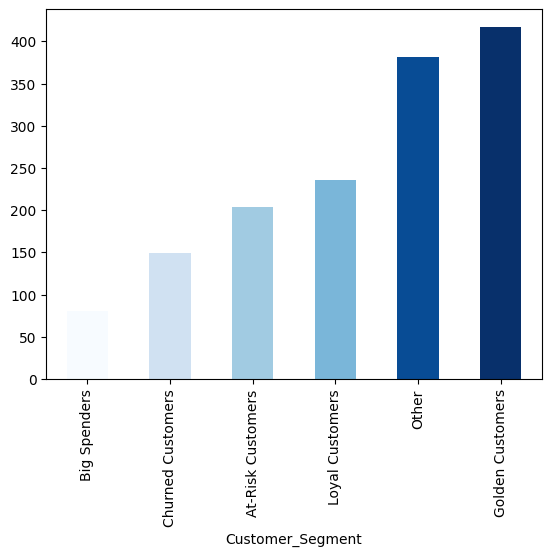

In [42]:
rfm.groupby('Customer_Segment').size().sort_values().plot(kind = 'bar', color = bar_colors)

**Recommendation**

- Target High-Value Customers: Give special offers to Best Customers to retain them.
- Re-engage At-Risk & Churned Customers: Offer incentives to win back these customers.
- Identify Growth Opportunities: Analyze Big Spenders and turn them into Loyal Customers.

### Scientific Methods: K-means

In [43]:
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [44]:
# Standardize the RFM Values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

In [45]:
# Determine the Optimal Number of Clusters using the Elbow Method
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

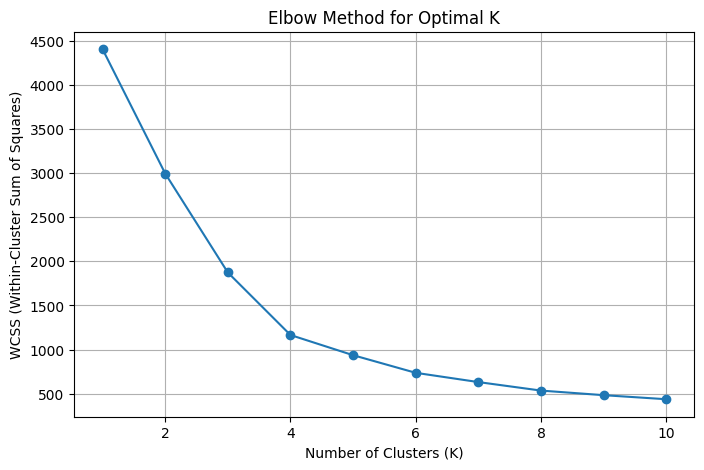

In [46]:
# Plot the Elbow Method graph
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.grid()
plt.show()

In [47]:
# Apply K-Means Clustering with the Optimal Number of Clusters (Choose K=4 based on elbow method)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

### Comparing value-based and K-means Results

**Build the pivot table to see the difference based on counts**

In [48]:
# build the pivot table to see the difference
segments_comparision = rfm.groupby(['Cluster', 'Customer_Segment']).size().reset_index(name = 'Count')

pivot_df = segments_comparision.pivot(index='Cluster', columns='Customer_Segment', values='Count').fillna(0)

In [49]:
display(pivot_df)

Customer_Segment,At-Risk Customers,Big Spenders,Churned Customers,Golden Customers,Loyal Customers,Other
Cluster,,,,,,
0,125.0,38.0,149.0,0.0,182.0,214.0
1,0.0,0.0,0.0,8.0,1.0,0.0
2,79.0,43.0,0.0,409.0,53.0,167.0


**Compare results via visualization**

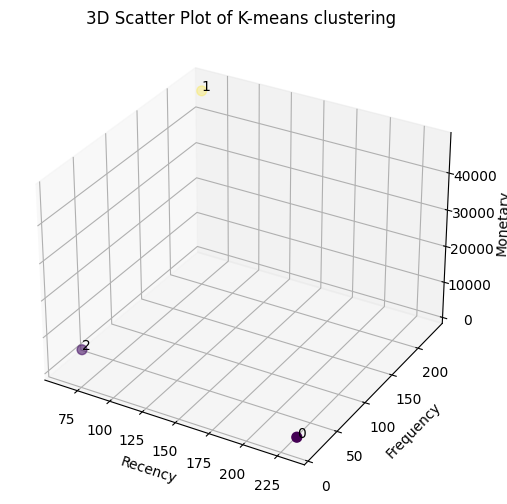

In [50]:
clusters_rfm = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using RFM as axes
ax.scatter(clusters_rfm['Recency'], clusters_rfm['Frequency'], clusters_rfm['Monetary'], 
           c=clusters_rfm['Monetary'], cmap='viridis', s=50)

# Labels for each point (using clusters number)
for i, (x, y, z) in enumerate(zip(clusters_rfm['Recency'], clusters_rfm['Frequency'], clusters_rfm['Monetary'])):
    ax.text(x, y, z, str(i), fontsize=10, color='black')

# Labels
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D Scatter Plot of K-means clustering')

plt.show()


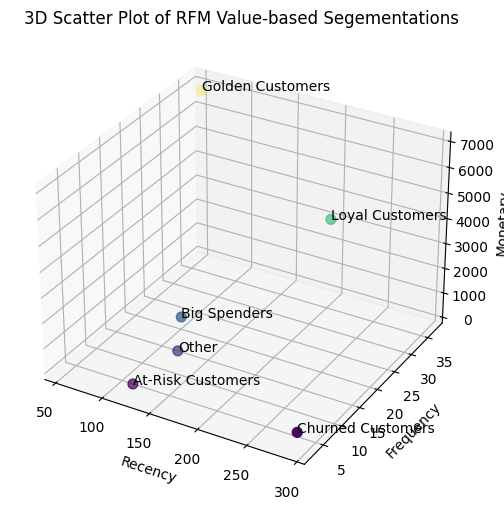

In [51]:
segment_rfm = rfm.groupby('Customer_Segment')[['Recency', 'Frequency', 'Monetary']].mean()

# Create a figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using RFM as axes
ax.scatter(segment_rfm['Recency'], segment_rfm['Frequency'], segment_rfm['Monetary'], 
           c=segment_rfm['Monetary'], cmap='viridis', s=50)

# Labeling each point with its index (Customer Segment)
for label, x, y, z in zip(segment_rfm.index, segment_rfm['Recency'], segment_rfm['Frequency'], segment_rfm['Monetary']):
    ax.text(x, y, z, label, fontsize=10, color='black')

# Labels
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D Scatter Plot of RFM Value-based Segementations')

plt.show()


**Observation:**

While K-means allow us to identify the natural patterns behind the data, value-based method provides us with clear business interpretation, allowing us to define customer groups in a way that aligns with marketing strategies.

The two methods generally align, indicating that the customer groups found by K-Means reflect meaningful segmentation in the business context.

On the other hand, "Loyal Customers" is not captured by K-Means. This suggests that Loyal Customers may not be as distinct in the feature space when using an unsupervised approach, possibly due to overlapping patterns with other segments.

It's important to note that value-based method identifies more granular segments in our case. Cluster 2 in K-Means closely resembles multiple RFM segments, meaning that K-Means may have combined multiple behavioral types into a single group.

Since value-based method not only successfully captures the patterns identified by K-means and it also provides us with more granularity, I'd recommend to follow the RFM method to obtain the customer segments and apply some marketing strategies targeting these customers.
